<a href="https://colab.research.google.com/github/tshrove/phd-project/blob/master/JIRA_Github_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import numpy as np
from IPython.display import display
import warnings

%matplotlib inline
#plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 200

jira_project_names = ['CDRIVER', 'CSHARP', 'JAVA', 'NODE', 'PERL', 'PYTHON', 'RUBY']
github_project_names = ['mongodb/mongo-c-driver', 'mongodb/mongo-csharp-driver', 'mongodb/mongo-java-driver', 
                        'mongodb/node-mongodb-native', 'mongodb/mongo-perl-driver', 'mongodb/mongo-python-driver', 'mongodb/mongo-ruby-driver']

sampling_freq = 'M'
weeks_of_prediction = 4
weeks_of_training = 10
do_plot = False
do_print = False

warnings.filterwarnings('ignore')

## Getting the Defect Data
Need to get the defect data from excel spreadsheet.

In [2]:
from google.colab import files

uploaded = files.upload()
  
# Import TD data
defects_dataframe = pd.read_csv('SELECT_t___FROM_db_dbprojecttdevent4_t.csv', index_col = 0, parse_dates=True)
# Convert event_date column to datetime column for analysis
defects_dataframe['event_date'] = pd.to_datetime(defects_dataframe['event_date'])
defects_dataframe = defects_dataframe.set_index('event_date')

Saving SELECT_t___FROM_db_dbprojecttdevent4_t.csv to SELECT_t___FROM_db_dbprojecttdevent4_t.csv


## Getting the Stargazer Data.
Need to get the stargazer data from the excel spreadsheet.

In [3]:
uploaded = files.upload()

# Import DBStar Data
stargazer_dataframe = pd.read_csv('SELECT_t___FROM_db_dbstar_t.csv', index_col = 0, parse_dates=True)
# Convert event_date column to datetime column for analysis
stargazer_dataframe['event_date'] = pd.to_datetime(stargazer_dataframe['event_date'])
stargazer_dataframe = stargazer_dataframe.set_index('event_date')

Saving SELECT_t___FROM_db_dbstar_t.csv to SELECT_t___FROM_db_dbstar_t.csv


##  Getting and Filtering the Data
Here we are filter the data to the exact projects we need it from and plotting it out.

In [0]:
def get_filter_data(jira_proj, github_proj):
  # filter td data to one project
  df1 = defects_dataframe[defects_dataframe.projectkey == jira_proj]
  # filter stargazer data to one project
  df2 = stargazer_dataframe[stargazer_dataframe.repokey == github_proj]
  return df1, df2

## Create a column normalization function to use.

In [0]:
def normalize_column(df, column_name):
  # Create x, where x the 'scores' column's values as floats
  x = df[[column_name]].values.astype(float)

  # Create a minimum and maximum processor object
  min_max_scaler = preprocessing.MinMaxScaler()

  # Create an object to transform the data to fit minmax processor
  x_scaled = min_max_scaler.fit_transform(x)

  # Run the normalizer on the dataframe
  return x_scaled

Use the normalization function on both datasets and plot the results.

In [0]:
def normalize_cumlative_value_col(column_name, df1, df2):
  df1['cumlative_value_percentage'] = normalize_column(df1, column_name)
  df2['cumlative_value_percentage'] = normalize_column(df2, column_name)
  return df1, df2

## Finding the earliest and most recent dates
We are trying to find the earliest and most recent datas on the project in order to now how long the actual project lasted.

In [0]:
def find_oldest_and_most_recent_dates(df1, df2, col_name):
  #remove the indexing
  df1.reset_index(inplace=True)
  df2.reset_index(inplace=True)

  # find the normalization min value for x axis
  earliest_sg_date = df2[col_name].min()
  earliest_td_date = df1[col_name].min()
  earliest_date = min(earliest_sg_date, earliest_td_date)

  #find the normalization max value for x axis
  most_recent_sg_date = df2[col_name].max()
  most_recent_td_date = df1[col_name].max()
  most_recent_date = min(most_recent_sg_date, most_recent_td_date)
  
  return earliest_date, most_recent_date

## Resample the DataFrame
Need to resample the series for the specified sampling frequency and reset the index.

In [0]:
def resample_dataframe(df):
  df.groupby('event_date').cumlative_value_percentage.last()
  df.drop_duplicates(subset='event_date', keep='last', inplace=True)
  df = df.set_index('event_date')
  df = df.resample(sampling_freq).mean().bfill()
  return df

## Merge Dataframes Together
Merged the two dataframes togther in order to have a single index.

In [0]:
#
# merging the two data points together in order to normalize on the x axis
#
def merge_two_dataframes(df1, df2, early_date, latest_date, samp_freq):
  merged_df = pd.DataFrame(columns=['date', 'td', 'sg'])
  merged_df['date'] = pd.date_range(early_date, latest_date, freq=samp_freq, normalize=True)
  merged_df = merged_df.set_index('date')
  merged_df['sg'] = df2['cumlative_value_percentage']
  merged_df['td'] = df1['cumlative_value_percentage']
  merged_df['td'][0] = 0
  merged_df['td'] = merged_df['td'].fillna(method='ffill')
  return merged_df

In [0]:
#
# Perform the normalization
#
def create_and_normalize_new_index(df):
  scalar = MinMaxScaler(feature_range=(0, 1))
  scaled_merged_df = scalar.fit_transform(df)
  scaled_merged_df = pd.DataFrame(scaled_merged_df, columns=['td', 'sg'])
  scaled_merged_df['normalized_index'] = scaled_merged_df.index.tolist() / scaled_merged_df.index.to_series().count()
  scaled_merged_df = scaled_merged_df.set_index('normalized_index')
  return scaled_merged_df

## Create SP2D2 metric

In [0]:
def create_sp2d2_series(df):
  df['td_pct_diff'] = df['td'].pct_change().fillna(0)
  df['sg_pct_diff'] = df['sg'].pct_change().fillna(0)
  df['sp2d2'] = df['sg'] - df['td']
  df['sp2d2'] = df['sp2d2'].replace([np.inf, -np.inf], np.nan)
  return df

## Split the Data for Training and Testing
Here I am splitting the data into training and test data. I could've used the split_train_test function however, it would not return something or perform the correct action I needed so i created my own. I also needed two training datasets.

In [0]:
def split_data_train_test(df):
  # put the data into np arrays
  x = np.array(df.index.tolist()).reshape(-1, 1)
  y = np.array(df['sp2d2']).reshape(-1, 1)

  # split the data into training and test data.
  n = len(x)
  x_train = x[:int(n - weeks_of_prediction)]
  x_test = x[int(n - weeks_of_prediction):]

  # further splitting (split training data into 10% of original training size)
  n=len(x_train)
  x_train2 = x_train[int(n - weeks_of_training):]

  m = len(y)
  y_train = y[:int(m - weeks_of_prediction)]
  y_test = y[int(m - weeks_of_prediction):]

  # further splitting (split training data into 10% of original training size)
  m=len(y_train)
  y_train2 = y_train[int(m - weeks_of_training):]
  return x_train, x_test, y_train, y_test, x_train2, y_train2

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def linear_regression(x_train, y_train, x_test):
  poly_reg = PolynomialFeatures(degree=1, interaction_only=False, include_bias=False)
  x_poly = poly_reg.fit_transform(x_train)
  pol_reg = LinearRegression()
  pol_reg.fit(x_poly, y_train)
  y_hat = pol_reg.predict(poly_reg.fit_transform(x_test))
  return y_hat

In [0]:
# from sklearn.metrics import mean_squared_error

# # Get the mean squared error
# mse = mean_squared_error(y_test, y_predict)
# print(mse)

In [0]:
def plot_everything(x_train, y_train, x_test, y_test, x_train2, y_train2, y_predict):
  if do_plot == True:
    # plot the data
    plt.plot(x_train, y_train, c='r', label='training data')
    plt.plot(x_test, y_test, c='b', label='testing data')
    plt.plot(x_train2, y_train2, c='g', label='testing data')
    plt.plot(x_test, y_predict, c='y', label='regression')
    plt.show()

In [0]:
def all_steps(jira_project, github_project):
  
  node_dataframe = None
  node_sg_dataframe = None
  
  #step 1
  node_dataframe, node_sg_dataframe = get_filter_data(jira_project, github_project)
  if do_plot == True:
    ax1 = plt.subplot(211)
    node_dataframe['cumlative_value'].plot(ax=ax1)
    ax2 = plt.subplot(212)
    node_sg_dataframe['cumlative_value'].plot(ax=ax2)
    plt.show()
  
  #step 2
  node_dataframe, node_sg_dataframe = normalize_cumlative_value_col('cumlative_value', node_dataframe, node_sg_dataframe)
  # Get the data to a series of the cumlative_value column
  if do_plot == True:
    ax3 = plt.subplot(211)
    node_dataframe['cumlative_value_percentage'].plot(ax=ax3)
    ax4 = plt.subplot(212)
    node_sg_dataframe['cumlative_value_percentage'].plot(ax=ax4)
    plt.show()
  
  #step 3
  earliest_date, most_recent_date = find_oldest_and_most_recent_dates(node_dataframe, node_sg_dataframe, 'event_date')
  
  #step 4
  node_dataframe = resample_dataframe(node_dataframe)
  if do_plot == True:
    node_dataframe['cumlative_value_percentage'].plot()
    
  node_sg_dataframe = resample_dataframe(node_sg_dataframe)
  if do_plot == True:
    node_sg_dataframe['cumlative_value_percentage'].plot()
    plt.show()
  
  #step 5
  merged_df = merge_two_dataframes(node_dataframe, node_sg_dataframe, earliest_date, most_recent_date, sampling_freq)
  if do_plot == True:
    merged_df.plot()
    plt.show()
  
  #step 6
  scaled_merged_df = create_and_normalize_new_index(merged_df)
  if do_plot == True:
    scaled_merged_df.plot()
    plt.show()
  
  #step 7
  scaled_merged_df = create_sp2d2_series(scaled_merged_df)
  if do_plot == True:
    scaled_merged_df.plot(y='sp2d2')
    plt.show()
  
  #step 8
  x_train, x_test, y_train, y_test, x_train2, y_train2 = split_data_train_test(scaled_merged_df)
  if do_plot == True:
    # plot the data
    plt.plot(x_train, y_train, c='r', label='training data')
    plt.plot(x_test, y_test, c='b', label='testing data')
    plt.plot(x_train2, y_train2, c='g', label='testing data')
    plt.show()
  
  #step 9
  y_predict = linear_regression(x_train2, y_train2, x_test)
  
  #step 11
  plot_everything(x_train, y_train, x_test, y_test, x_train2, y_train2, y_predict)
  
  #step 10
  # Get the mean squared error
  mse = mean_squared_error(y_test, y_predict)
  return mse

In [0]:
def do_all(jira_projects, github_projects):
  mse_list = []
  for (jira_proj, github_proj) in zip(jira_projects, github_projects):
    mse = all_steps(jira_proj, github_proj)
    mse_list.append(mse)
    if do_print == True:
      print(jira_proj, github_proj, ": \t", mse)
  # get the average mse
  mse_avg = sum(mse_list) / len(mse_list)
  if do_print == True:
    print ('average mse: ', mse_avg)
  return mse_avg

In [27]:
do_all(jira_project_names, github_project_names)

CDRIVER mongodb/mongo-c-driver : 	 0.04663694378483563
CSHARP mongodb/mongo-csharp-driver : 	 0.0047106210424027375
JAVA mongodb/mongo-java-driver : 	 0.004975942230390115
NODE mongodb/node-mongodb-native : 	 0.03472320631626385
PERL mongodb/mongo-perl-driver : 	 0.000669214783651167
PYTHON mongodb/mongo-python-driver : 	 0.014377061446974919
RUBY mongodb/mongo-ruby-driver : 	 0.014696147755489542
average mse:  0.017255591051429712


months of training:  6  months of prediction:  1  average MSE:  0.0065352046034705515
months of training:  6  months of prediction:  2  average MSE:  0.00876753897862372
months of training:  6  months of prediction:  3  average MSE:  0.02741264570067014
months of training:  6  months of prediction:  4  average MSE:  0.024474582639376245
months of training:  6  months of prediction:  5  average MSE:  0.02102569392040682
months of training:  6  months of prediction:  6  average MSE:  0.012543845663414335
months of training:  6  months of prediction:  7  average MSE:  0.03747202567425538
months of training:  6  months of prediction:  8  average MSE:  0.11920127793246062
months of training:  6  months of prediction:  9  average MSE:  0.1592150887806861
months of training:  6  months of prediction:  10  average MSE:  0.09832006466031448
months of training:  6  months of prediction:  11  average MSE:  0.05690952245161148
months of training:  7  months of prediction:  1  average MSE:  0.00533

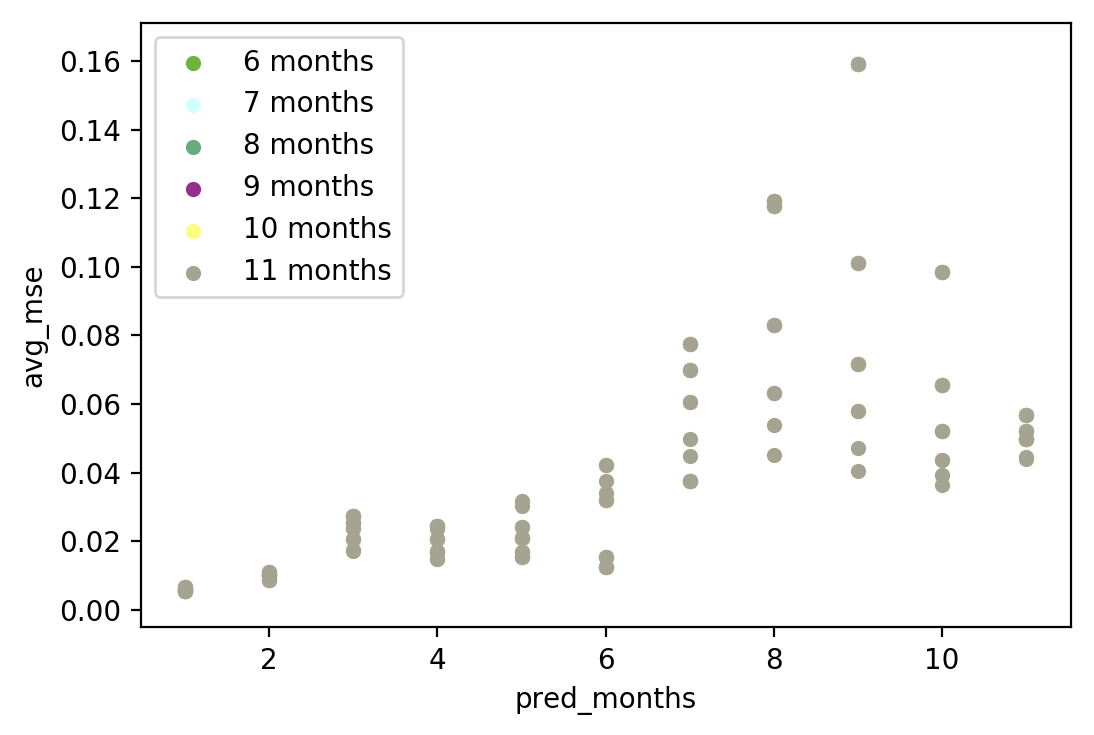

In [64]:
from matplotlib import colors
df = pd.DataFrame(columns=['train_months', 'pred_months', 'avg_mse'])
ax = plt.gca()
# for some reason matplotlib does not change the color of the plots automatically
colorlist = list(colors.ColorConverter.colors.keys())

for t in range(6, 12):
  weeks_of_training = t
  for i in range(1, 12):
    weeks_of_prediction = i
    mse_avg = do_all(jira_project_names, github_project_names)
    print('months of training: ', weeks_of_training, ' months of prediction: ', weeks_of_prediction, ' average MSE: ', mse_avg)
    df = df.append({'train_months' :  weeks_of_training, 'pred_months' : weeks_of_prediction, 'avg_mse': mse_avg} , ignore_index=True)
  #create plot label
  _label = str(t) + ' months'
  #plot it
  #df.sort_values(['train_months', 'pred_months'], ascending=[True, True])
  df.plot(kind='scatter', x='pred_months', y='avg_mse', label=_label, ax=ax, color=colorlist[t % len(colorlist)])
  
plt.show()

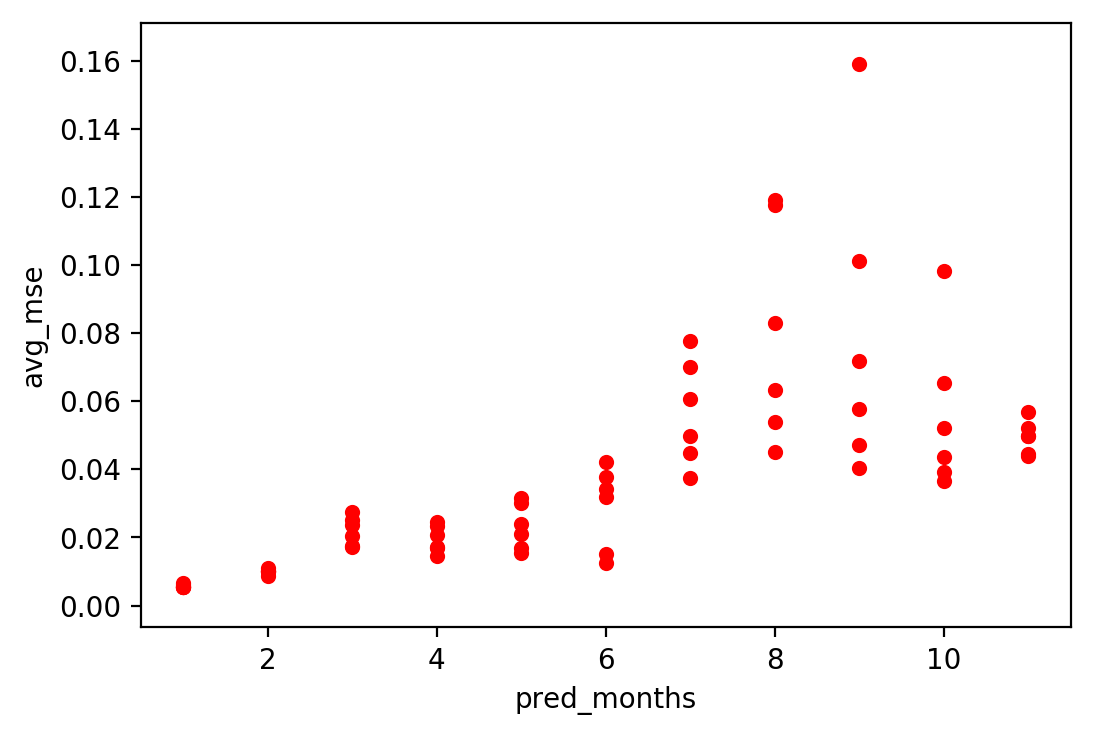

In [65]:
df.plot(kind='scatter', x='pred_months', y='avg_mse', color='red')
plt.show()